#Hospital Italiano de Buenos Aires Skin Lesions Dataset

In this notebook, we present the exploratory data analysis (EDA) performed for the Hospital Italiano de Buenos Aires Skin Lesions Dataset (available at https://doi.org/10.34970/432362). The results are consistent with the description presented in the corresponding section of the manuscript.

##Libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
!pip install isic-cli 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Dataset download

The dataset is registered as a collection in the International Skin Imaging Collaboration (ISIC) archive. It can be accessed through this [link](https://doi.org/10.34970/432362). We resort to the official command line tool for interacting with the ISIC Archive to download images and the corresponding metadata.  

In [70]:
!isic collection list 

Psst, you're logged out. Logging in with `isic user login` might return more data.

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ ID  ┃ Name                 ┃ Public ┃ Pinned ┃ Locked ┃ DOI                  ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 61  │ Challenge 2016: Test │ True   │ True   │ True   │ None                 │
│ 74  │ Challenge 2016:      │ True   │ True   │ True   │ None                 │
│     │ Training             │        │        │        │                      │
│ 69  │ Challenge 2017: Test │ True   │ True   │ True   │ None                 │
│ 60  │ Challenge 2017:      │ True   │ True   │ True   │ None                 │
│     │ Training             │        │        │        │                      │
│ 71  │ Challenge 2017:      │ True   │ True   │ True   │ None                 │
│     │ Validation           │        │        │        │                      │
│ 63  │ Challenge 2018: T

###Metadata

In [71]:
collection_id = 176
response = !isic metadata download --collections $collection_id

In [72]:
start_metadata_collection = False
metadata_keys = []

for line in response: 
  if 'isic_id' in line:
    col_names = line.split(',')
    col_names[0] = col_names[0][col_names[0].find('isic_id'):]
    data = pd.DataFrame(columns = col_names)
    start_metadata_collection = True
  elif start_metadata_collection:
    new_row = pd.DataFrame(dict(zip(col_names,line.split(','))), index=[0])
    data =  pd.concat([data, new_row])

In [73]:
data

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,benign_malignant,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
0,ISIC_6230191,Hospital Italiano de Buenos Aires,CC-BY-NC,25,anterior torso,malignant,contact polarized,melanoma,histopathology,,dermoscopic,IL_8124990,IP_8542863,True,640,480,male
0,ISIC_4485929,Hospital Italiano de Buenos Aires,CC-BY-NC,65,anterior torso,benign,contact polarized,seborrheic keratosis,,,dermoscopic,IL_1921228,IP_9326183,True,2448,2448,female
0,ISIC_3079785,Hospital Italiano de Buenos Aires,CC-BY-NC,45,lower extremity,benign,contact polarized,nevus,histopathology,False,dermoscopic,IL_3797557,IP_4906546,False,640,480,male
0,ISIC_9677008,Hospital Italiano de Buenos Aires,CC-BY-NC,30,posterior torso,malignant,contact polarized,melanoma,histopathology,,dermoscopic,IL_3556705,IP_5493434,True,1409,2900,female
0,ISIC_9129115,Hospital Italiano de Buenos Aires,CC-BY-NC,75,posterior torso,benign,,actinic keratosis,histopathology,,clinical,IL_2485486,IP_8947694,,498,1026,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ISIC_6874409,Hospital Italiano de Buenos Aires,CC-BY-NC,75,lower extremity,malignant,,basal cell carcinoma,histopathology,,clinical,IL_7279125,IP_4513580,,1420,1602,female
0,ISIC_4385084,Hospital Italiano de Buenos Aires,CC-BY-NC,75,lower extremity,malignant,contact polarized,basal cell carcinoma,histopathology,,dermoscopic,IL_7279125,IP_4513580,,1738,3574,female
0,ISIC_9314666,Hospital Italiano de Buenos Aires,CC-BY-NC,55,head/neck,benign,contact polarized,actinic keratosis,histopathology,,dermoscopic,IL_1313631,IP_7048742,,1918,933,female
0,ISIC_8229835,Hospital Italiano de Buenos Aires,CC-BY-NC,65,posterior torso,malignant,,basal cell carcinoma,histopathology,,clinical,IL_9261445,IP_4577038,,457,304,male


###Images

In [74]:
collection_id = 176
!isic image download --collections $collection_id images/

Psst, you're logged out. Logging in with `isic user login` might return more data.


Successfully downloaded 1,635 images to images/.
Successfully wrote 1,635 metadata records to images/metadata.csv.
Successfully wrote attributions to images/attribution.txt.


## Exploratory Data Analysis

### Patient, Lesions and Images distribution

In [75]:
lesions_per_patient = []
images_per_patient = []
derm_per_patient = []
clin_per_patient = []

for pat in data.patient_id.unique():
  aux = data[data.patient_id==pat]
  lesions_per_patient.append(len(aux.lesion_id.unique()))
  images_per_patient.append(len(aux))
  derm_per_patient.append(len(aux[aux.image_type=='dermoscopic']))
  clin_per_patient.append(len(aux[aux.image_type=='clinical']))

lesions_per_patient = np.asarray(lesions_per_patient)
images_per_patient = np.asarray(images_per_patient)
derm_per_patient = np.asarray(derm_per_patient)
clin_per_patient = np.asarray(clin_per_patient)

In [76]:
print(f'Total patients in the dataset: {len(data.patient_id.unique())}')

print(f'\nTotal unique lesions: {lesions_per_patient.sum()}')
print(f'Lesions per patient ---> MIN {lesions_per_patient.min()} | MAX {lesions_per_patient.max()} | MEAN {lesions_per_patient.mean()}| MEDIAN {np.median(lesions_per_patient)}')

print(f'\nTotal unique images: {len(data)}')
print(f'Images per patient ---> MIN {images_per_patient.min()} | MAX {images_per_patient.max()} | MEAN {images_per_patient.mean()}| MEDIAN {np.median(images_per_patient)}')

print(f'Dermoscopic images per patient ---> MIN {derm_per_patient.min()} | MAX {derm_per_patient.max()} | MEAN {derm_per_patient.mean()}| MEDIAN {np.median(derm_per_patient)}')

print(f'Clinical images per patient ---> MIN {clin_per_patient.min()} | MAX {clin_per_patient.max()} | MEAN {clin_per_patient.mean()}| MEDIAN {np.median(clin_per_patient)}')

Total patients in the dataset: 628

Total unique lesions: 1257
Lesions per patient ---> MIN 1 | MAX 63 | MEAN 2.001592356687898| MEDIAN 1.0

Total unique images: 1635
Images per patient ---> MIN 1 | MAX 63 | MEAN 2.6035031847133756| MEDIAN 2.0
Dermoscopic images per patient ---> MIN 0 | MAX 63 | MEAN 2.038216560509554| MEDIAN 1.0
Clinical images per patient ---> MIN 0 | MAX 8 | MEAN 0.5652866242038217| MEDIAN 0.0


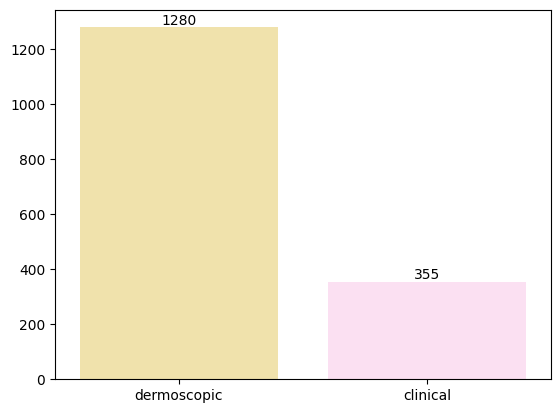

In [77]:
data.image_type.value_counts(dropna=False)

ax = sns.barplot(x=data.image_type.value_counts().keys(), y=data.image_type.value_counts().values, data=data, palette=['#FBE8A1', '#FFDCF4'])
_ = ax.bar_label(ax.containers[0])

In [78]:
images_per_lesion = []
derm_per_lesion = []
clin_per_lesion = []

for pat in data.patient_id.unique():
  aux = data[data.patient_id==pat]
  
  for les in aux.lesion_id.unique():
    aux2 = aux[aux.lesion_id==les]
    images_per_lesion.append(len(aux2))
    derm_per_lesion.append(len(aux2[aux2.image_type=='dermoscopic']))
    clin_per_lesion.append(len(aux2[aux2.image_type=='clinical']))

images_per_lesion = np.asarray(images_per_lesion)
derm_per_lesion = np.asarray(derm_per_lesion)
clin_per_lesion = np.asarray(clin_per_lesion)

In [79]:
print(f'Total images: {images_per_lesion.sum()}')
print(f'Total dermoscopic images: {derm_per_lesion.sum()}')
print(f'Total clinical images: {clin_per_lesion.sum()}')
print(f'Sum of dermoscopic and clinical images: {derm_per_lesion.sum()+clin_per_lesion.sum()}')

Total images: 1635
Total dermoscopic images: 1280
Total clinical images: 355
Sum of dermoscopic and clinical images: 1635


In [80]:
print(f'Images per lesion ---> MIN {images_per_lesion.min()} | MAX {images_per_lesion.max()} | MEAN {images_per_lesion.mean()}| MEDIAN {np.median(images_per_lesion)}')
print('Total unique lesions', images_per_lesion.sum())

print(f'\nDermoscopic images per lesion ---> MIN {derm_per_lesion.min()} | MAX {derm_per_lesion.max()} | MEAN {derm_per_lesion.mean()}| MEDIAN {np.median(derm_per_lesion)}')

print(f'\nClinical images per lesion ---> MIN {clin_per_lesion.min()} | MAX {clin_per_lesion.max()} | MEAN {clin_per_lesion.mean()}| MEDIAN {np.median(clin_per_lesion)}')

Images per lesion ---> MIN 1 | MAX 6 | MEAN 1.3007159904534606| MEDIAN 1.0
Total unique lesions 1635

Dermoscopic images per lesion ---> MIN 0 | MAX 5 | MEAN 1.0182975338106603| MEDIAN 1.0

Clinical images per lesion ---> MIN 0 | MAX 2 | MEAN 0.2824184566428003| MEDIAN 0.0


### Patient characteristics

In [81]:
patient_data = data[['patient_id','age_approx', 'sex','personal_hx_mm', 'family_hx_mm']].reset_index(drop=True) #at the time of consultation
patient_data.drop_duplicates(['patient_id'],inplace=True)
patient_data.reset_index(inplace=True,drop=True)
patient_data

,patient_id,age_approx,sex,personal_hx_mm,family_hx_mm
0,IP_8542863,25,male,True,
1,IP_9326183,65,female,True,
2,IP_4906546,45,male,False,False
3,IP_5493434,30,female,True,
4,IP_8947694,75,female,,
...,...,...,...,...,...
623,IP_6251525,75,female,True,False
624,IP_4132519,25,female,False,False
625,IP_4513580,75,female,,
626,IP_7048742,55,female,,


####Age

Patient/s without age_approx informed:  5
Corresponding %:  0.7961783439490446

Patients age ---> MIN 5.0 | MAX 85.0 | MEAN 61.95826645264847 | SD 17.565262549615575


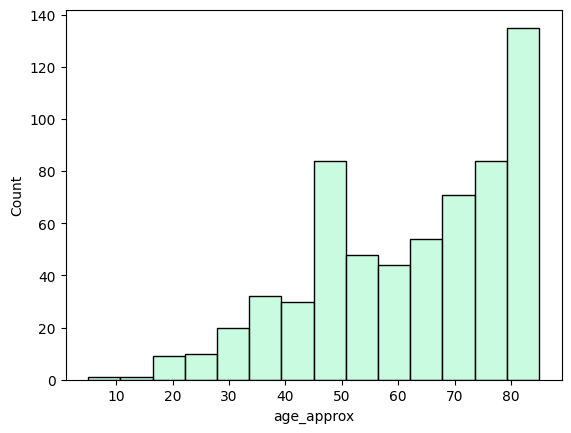

In [82]:
patient_data.age_approx = patient_data.age_approx.replace('', np.nan)
patient_data.age_approx = patient_data.age_approx.astype('float')

pvc = patient_data.age_approx.value_counts(dropna=False)
print('Patient/s without age_approx informed: ', pvc[np.nan])
print('Corresponding %: ', (pvc[np.nan]/len(patient_data)*100))

print(f'\nPatients age ---> MIN {patient_data.age_approx.min()} | MAX {patient_data.age_approx.max()} | MEAN {patient_data.age_approx.mean()} | SD {patient_data.age_approx.std()}')


_ = sns.histplot(patient_data.age_approx, color='#B7FAD7')

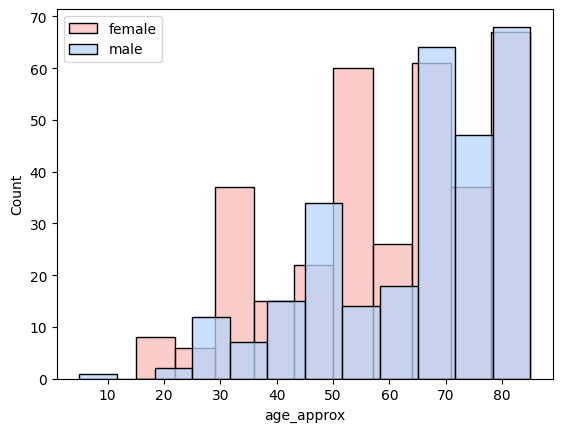

In [83]:
female_px = patient_data[patient_data.sex=='female']
male_px = patient_data[patient_data.sex=='male']
_ = sns.histplot(female_px.age_approx, color='#FABCB7', label='female')
_ = sns.histplot(male_px.age_approx, color='#B7D5FA', label='male')
_ = plt.legend() 

####Sex

In [84]:
patient_data.sex = patient_data.sex.replace('', np.nan)
pvc = patient_data.sex.value_counts(dropna=False)
print('Patient/s without sex informed: ', pvc[np.nan])
print('Corresponding %: ', (pvc[np.nan]/len(patient_data)*100) )

print('\nTotal female patients: ', len(female_px))
print('Total male patients: ', len(male_px))
print('Total patients: ', len(female_px)+len(male_px)+pvc[np.nan])

Patient/s without sex informed:  2
Corresponding %:  0.3184713375796179

Total female patients:  342
Total male patients:  284
Total patients:  628


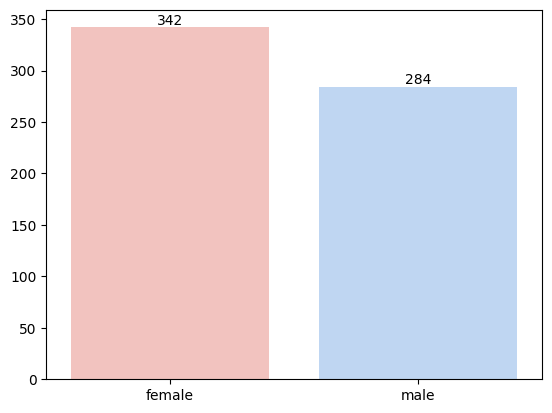

In [85]:
ax = sns.barplot(x=patient_data.sex.value_counts(dropna=False).keys(), y=patient_data.sex.value_counts(dropna=False).values, data=patient_data, palette=['#FABCB7', '#B7D5FA'])
_ = ax.bar_label(ax.containers[0])

####Personal and Familiy History of Melanoma

Possible combinations PERSONAL_HISTORY - FAMILIY_HISTORY

* Unk-Unk
* Unk-True
* Unk-False
* True-Unk
* False-Unk
* True-True
* True-False
* False-False
* False-True

In [86]:
print('Personal History of Melanoma\n')
patient_data.personal_hx_mm = patient_data.personal_hx_mm.replace('', np.nan)
patient_data.personal_hx_mm.value_counts(dropna=False)

Personal History of Melanoma



NaN      342
True     152
False    134
Name: personal_hx_mm, dtype: int64

In [87]:
print('Family History of Melanoma\n')
patient_data.family_hx_mm = patient_data.family_hx_mm.replace('', np.nan)
patient_data.family_hx_mm.value_counts(dropna=False)

Family History of Melanoma



NaN      391
False    206
True      31
Name: family_hx_mm, dtype: int64

In [88]:
print('Different combination of Personal and Family History of Melanoma\n')
unk_unk = patient_data[(patient_data.personal_hx_mm.isnull()) & (patient_data.family_hx_mm.isnull())]
print('> Unkown - Unknown  ', len(unk_unk))

unk_true = patient_data[(patient_data.personal_hx_mm.isnull()) & (patient_data.family_hx_mm=='True')]
print('> Unkown - True     ', len(unk_true))

unk_false = patient_data[(patient_data.personal_hx_mm.isnull()) & (patient_data.family_hx_mm=='False')]
print('> Unkown - False    ', len(unk_false))

true_unk = patient_data[(patient_data.personal_hx_mm=='True') & (patient_data.family_hx_mm.isnull())]
print('> True - Unknown    ', len(true_unk))

false_unk = patient_data[(patient_data.personal_hx_mm=='False') & (patient_data.family_hx_mm.isnull())]
print('> False - Unknown   ', len(false_unk))

true_true = patient_data[(patient_data.personal_hx_mm=='True') & (patient_data.family_hx_mm=='True')]
print('> True - True       ', len(true_true))

true_false = patient_data[(patient_data.personal_hx_mm=='True') & (patient_data.family_hx_mm=='False')]
print('> True - False      ', len(true_false))

false_false = patient_data[(patient_data.personal_hx_mm=='False') & (patient_data.family_hx_mm=='False')]
print('> False - False     ', len(false_false))

false_true = patient_data[(patient_data.personal_hx_mm=='False') & (patient_data.family_hx_mm=='True')]
print('> False - True      ', len(false_true))

Different combination of Personal and Family History of Melanoma

> Unkown - Unknown   336
> Unkown - True      6
> Unkown - False     0
> True - Unknown     50
> False - Unknown    5
> True - True        7
> True - False       95
> False - False      111
> False - True       18


In [101]:
total_px = len(patient_data)
least_one_unk = len(unk_unk)+len(unk_true)+len(unk_false)+len(true_unk)+len(false_unk)

print(f'At least one history record is unknown: {(least_one_unk/total_px)*100} %')

At least one history record is unknown: 63.21656050955414 %


In [90]:
unk_unk = patient_data[(patient_data.personal_hx_mm.isnull()) & (patient_data.family_hx_mm.isnull())]
print(f'Unknown personal and family history of MM:  {len(unk_unk)} - {(len(unk_unk)/total_px)*100} %')

pvc = patient_data.personal_hx_mm.value_counts(dropna=False)
print(f'\nPersonal history of MM: \n  {(pvc[np.nan]/total_px)*100} % unknown \n  {(pvc["True"]/total_px)*100} % yes \n  {(pvc["False"]/total_px)*100} % no')

pvc = patient_data.family_hx_mm.value_counts(dropna=False)
print(f'\nFamily history of MM: \n  {(pvc[np.nan]/total_px)*100} % unknown \n  {(pvc["True"]/total_px)*100} % yes \n  {(pvc["False"]/total_px)*100} % no')

false_false_p = patient_data[(patient_data.personal_hx_mm=='False') & (patient_data.family_hx_mm=='False')]
print(f'\nNegative personal and family history of MM {(len(false_false_p)/total_px)*100} %')

true_true_p = patient_data[(patient_data.personal_hx_mm=='True') & (patient_data.family_hx_mm=='True')]
print(f'\nPositive personal and family history of MM {(len(true_true_p)/total_px)*100} %')

Unknown personal and family history of MM:  336 - 53.503184713375795 %

Personal history of MM: 
  54.45859872611465 % unknown 
  24.203821656050955 % yes 
  21.337579617834397 % no

Family history of MM: 
  62.261146496815286 % unknown 
  4.936305732484077 % yes 
  32.802547770700635 % no

Negative personal and family history of MM 17.67515923566879 %

Positive personal and family history of MM 1.1146496815286624 %


###Lesion characteristics

In [91]:
lesion_data = data[['patient_id','lesion_id','benign_malignant', 'diagnosis','diagnosis_confirm_type', 'anatom_site_general']]
lesion_data.head()

,patient_id,lesion_id,benign_malignant,diagnosis,diagnosis_confirm_type,anatom_site_general
0,IP_8542863,IL_8124990,malignant,melanoma,histopathology,anterior torso
0,IP_9326183,IL_1921228,benign,seborrheic keratosis,,anterior torso
0,IP_4906546,IL_3797557,benign,nevus,histopathology,lower extremity
0,IP_5493434,IL_3556705,malignant,melanoma,histopathology,posterior torso
0,IP_8947694,IL_2485486,benign,actinic keratosis,histopathology,posterior torso


In [92]:
lesion_data.drop_duplicates(['patient_id', 'lesion_id'], inplace=True)
len(lesion_data)

<ipython-input-92-33b72bba6122>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lesion_data.drop_duplicates(['patient_id', 'lesion_id'], inplace=True)


1257

####Diagnosis - Confirmation - Benign/Malignant

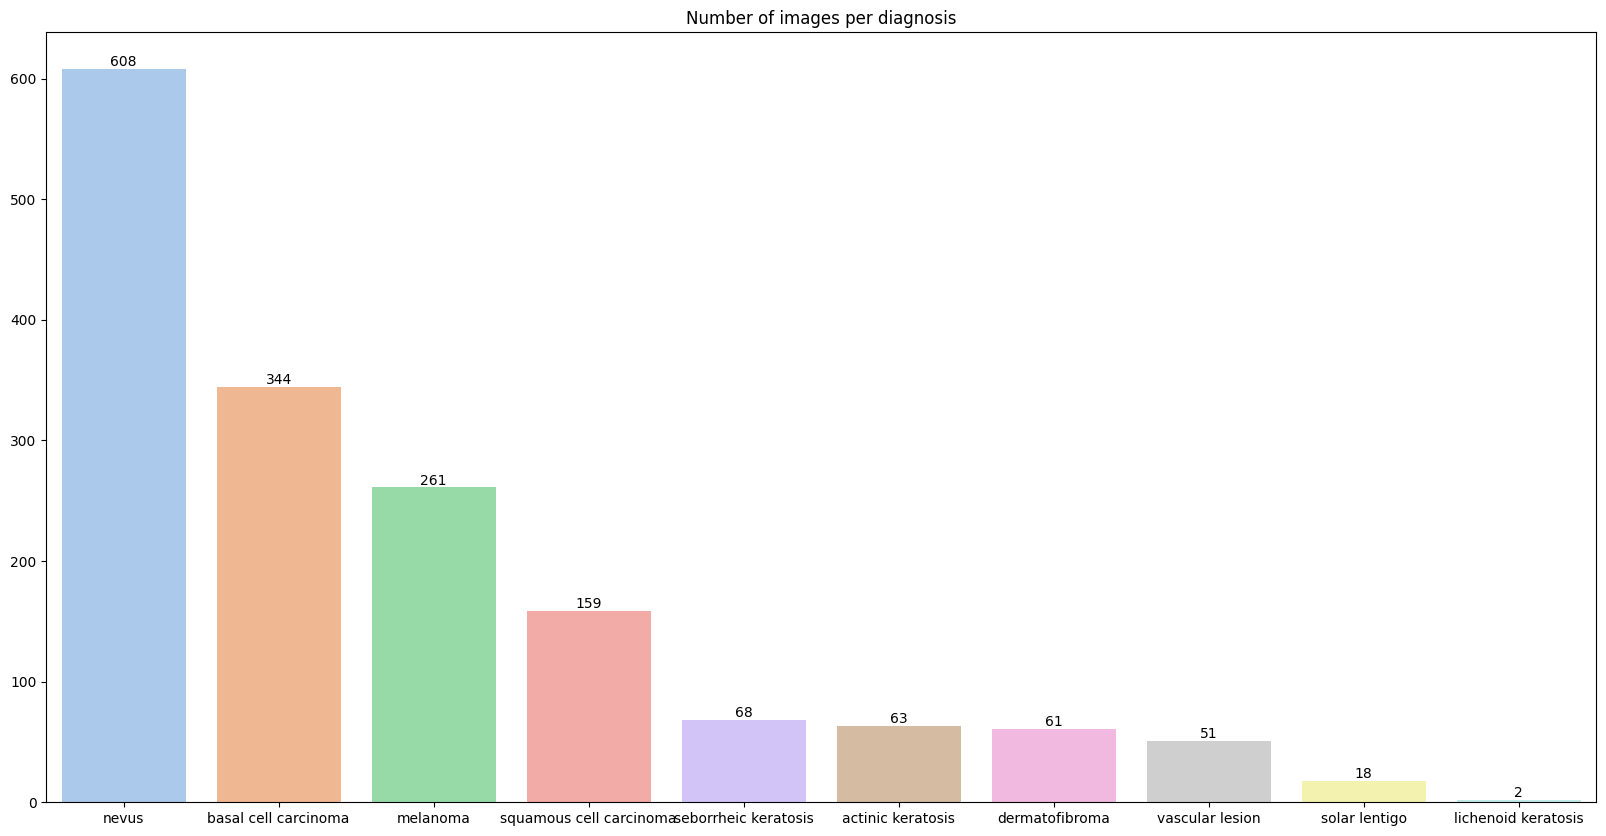

In [93]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=data.diagnosis.value_counts().keys(), y=data.diagnosis.value_counts().values, data=data, palette='pastel')
ax.set_title('Number of images per diagnosis')
_ = ax.bar_label(ax.containers[0])

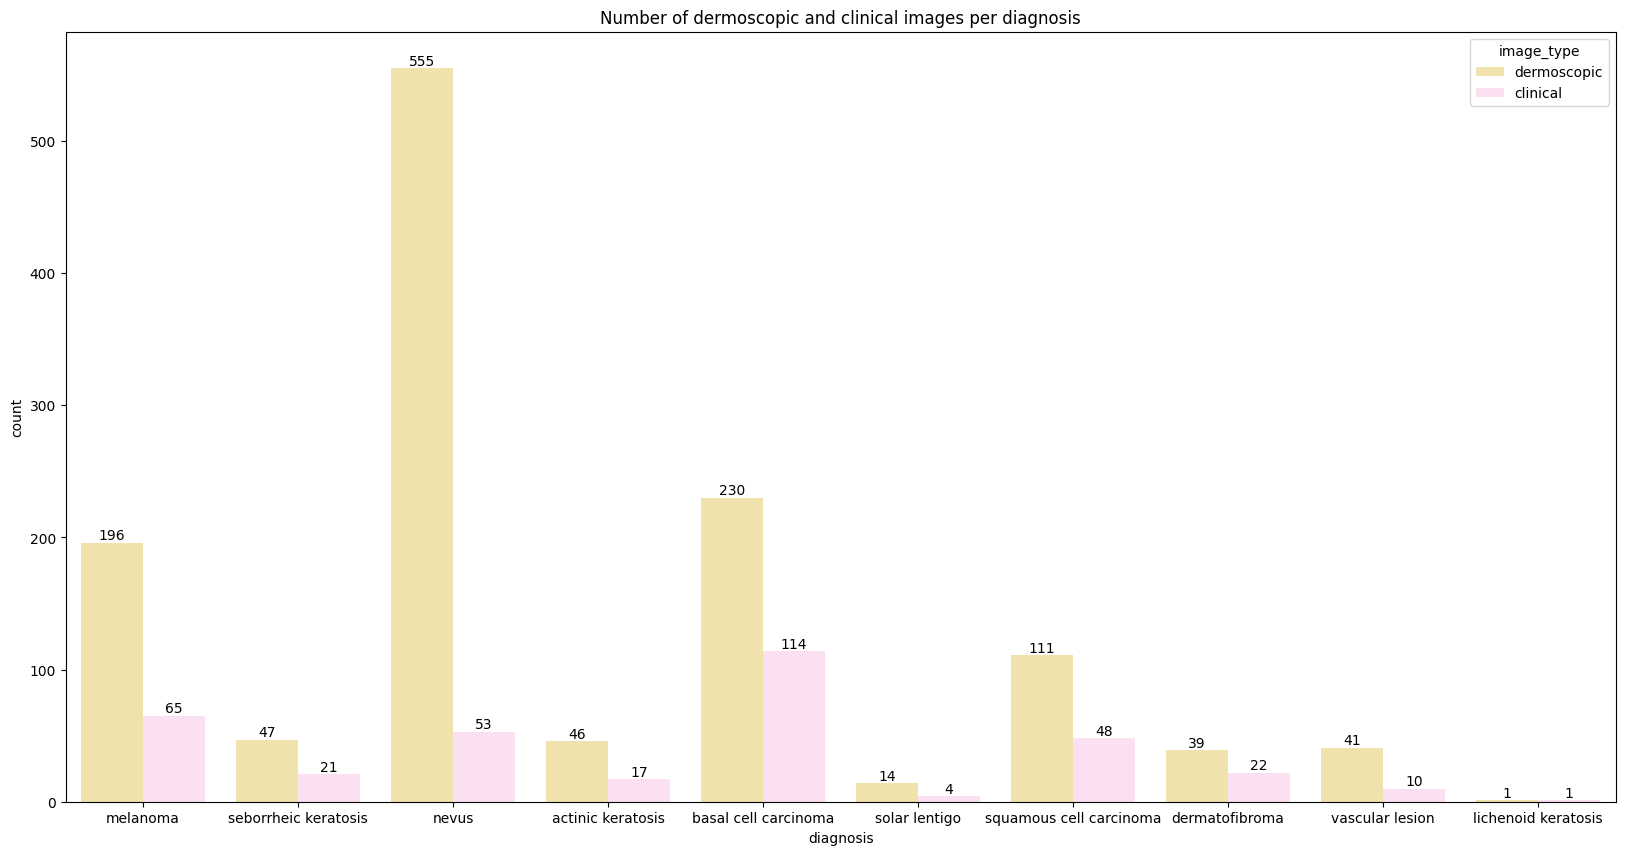

In [94]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x='diagnosis', hue='image_type', data=data, palette=['#FBE8A1', '#FFDCF4'])
ax.set_title('Number of dermoscopic and clinical images per diagnosis')
_ = ax.bar_label(ax.containers[0])
_ = ax.bar_label(ax.containers[1])

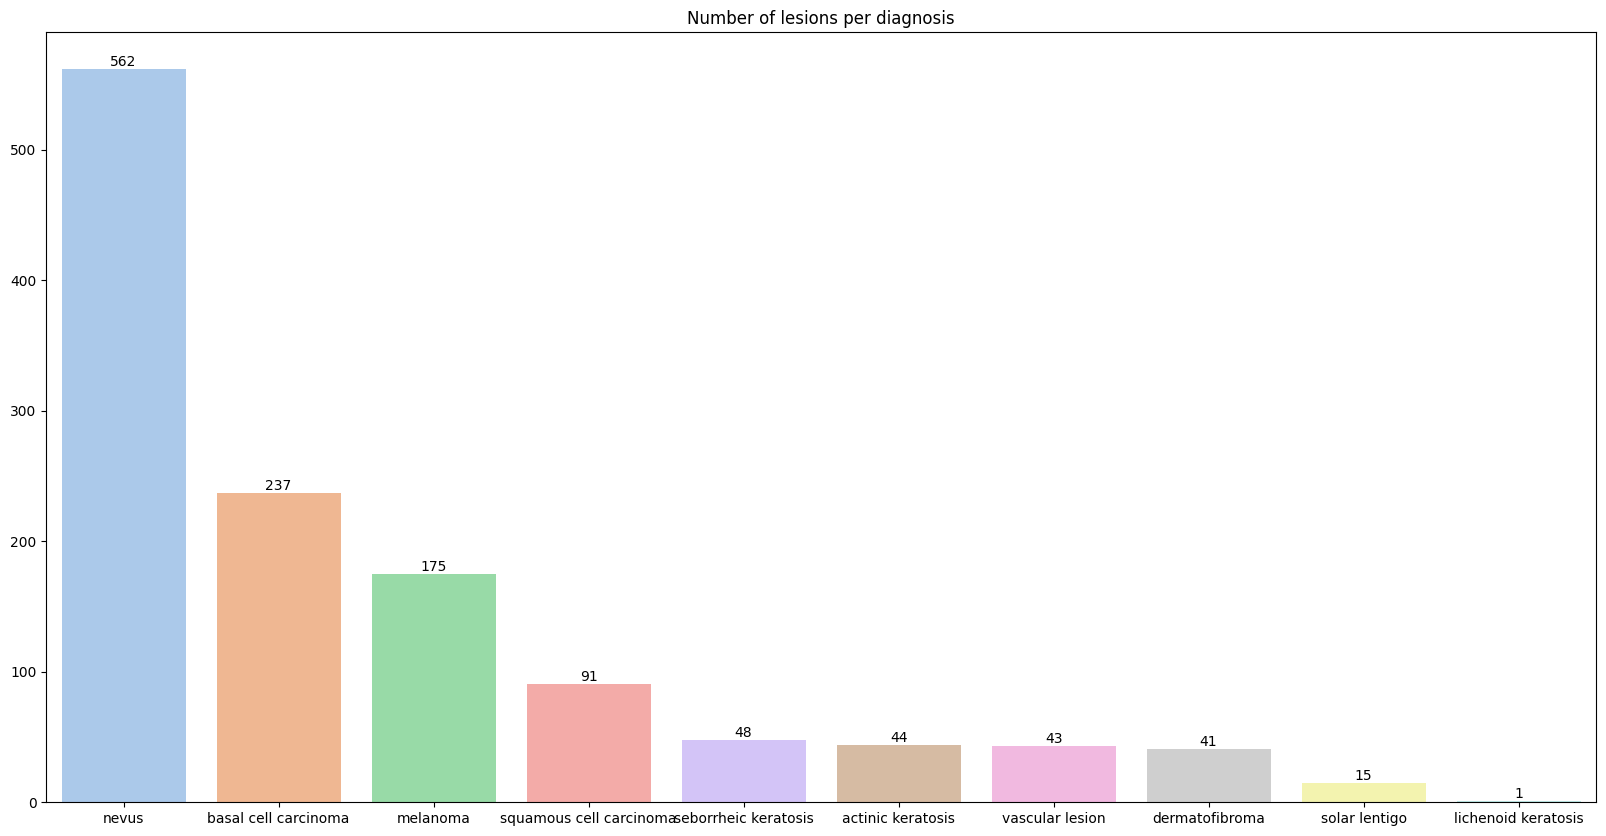

In [95]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=lesion_data.diagnosis.value_counts().keys(), y=lesion_data.diagnosis.value_counts().values, data=lesion_data, palette='pastel')
ax.set_title('Number of lesions per diagnosis')
_=ax.bar_label(ax.containers[0])

<ipython-input-96-2a6f2c281448>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lesion_data.diagnosis_confirm_type = lesion_data.diagnosis_confirm_type.replace('', 'single expert criteria')


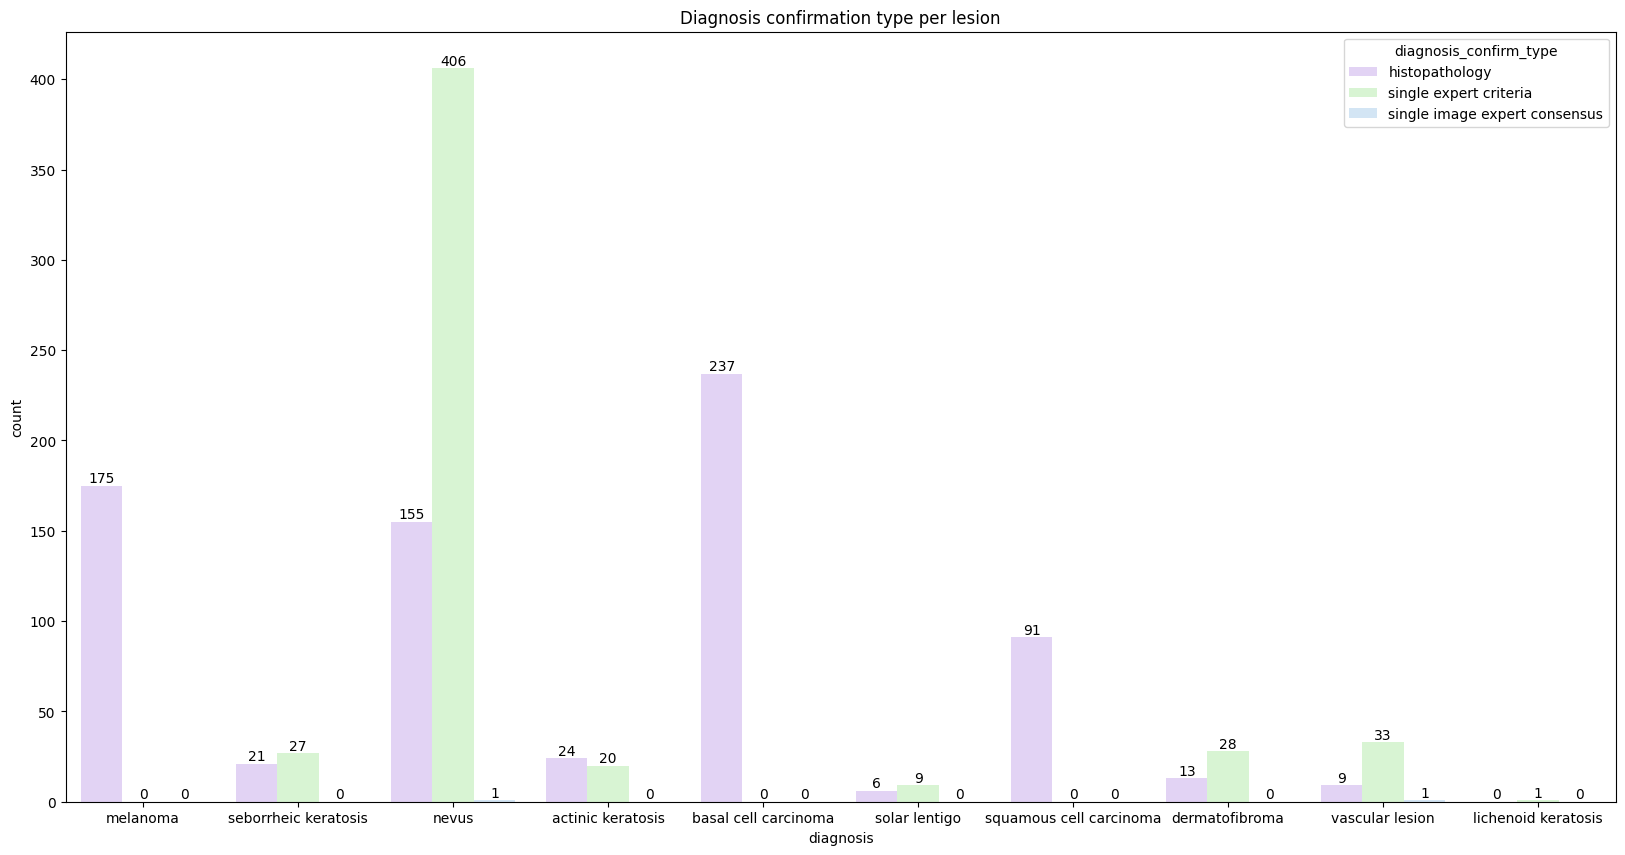

In [96]:
fig, ax = plt.subplots(figsize=(20,10))
lesion_data.diagnosis_confirm_type = lesion_data.diagnosis_confirm_type.replace('', 'single expert criteria')
ax = sns.countplot(x='diagnosis', hue='diagnosis_confirm_type', data=lesion_data, palette=['#E1CEF9', '#D4F9CE', '#CEE5F9'])
ax.set_title('Diagnosis confirmation type per lesion')
for i,v in enumerate(lesion_data.diagnosis_confirm_type.unique()):
  try:
    _=ax.bar_label(ax.containers[i])
  except:
    continue

In [97]:
for d in lesion_data.diagnosis.unique():
  try:
    aux = lesion_data[lesion_data.diagnosis==d]
    lvc = aux.diagnosis_confirm_type.value_counts()
    print(f'\n{d} --> {len(aux)} lesions - {(lvc["histopathology"]/len(aux))*100} % Histopathology Confirmation')
  except Exception as e: 
    print(f'\nFor lesion {d}, there is no confirmation by {e}')


melanoma --> 175 lesions - 100.0 % Histopathology Confirmation

seborrheic keratosis --> 48 lesions - 43.75 % Histopathology Confirmation

nevus --> 562 lesions - 27.580071174377224 % Histopathology Confirmation

actinic keratosis --> 44 lesions - 54.54545454545454 % Histopathology Confirmation

basal cell carcinoma --> 237 lesions - 100.0 % Histopathology Confirmation

solar lentigo --> 15 lesions - 40.0 % Histopathology Confirmation

squamous cell carcinoma --> 91 lesions - 100.0 % Histopathology Confirmation

dermatofibroma --> 41 lesions - 31.70731707317073 % Histopathology Confirmation

vascular lesion --> 43 lesions - 20.930232558139537 % Histopathology Confirmation

For lesion lichenoid keratosis, there is no confirmation by 'histopathology'


In [98]:
les_n = 0
AP_n = 0
for d in lesion_data.diagnosis.unique():
    aux = lesion_data[lesion_data.diagnosis==d]
    lvc = aux.diagnosis_confirm_type.value_counts()
    les_n += len(aux)
    try:
      AP_n += lvc["histopathology"]
    except Exception as e: 
      pass

print(f'\nTotal Histopathology Confirmation {(AP_n/les_n)*100}')


Total Histopathology Confirmation 58.154335719968174


####General Anatomical Site

In [99]:
lesion_data.anatom_site_general = lesion_data.anatom_site_general.replace('', np.nan)
lesion_data.anatom_site_general.value_counts(dropna=False)

<ipython-input-99-0b5b68988fea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lesion_data.anatom_site_general = lesion_data.anatom_site_general.replace('', np.nan)


head/neck          285
posterior torso    265
lower extremity    235
anterior torso     210
upper extremity    130
NaN                100
palms/soles         17
lateral torso        9
oral/genital         6
Name: anatom_site_general, dtype: int64

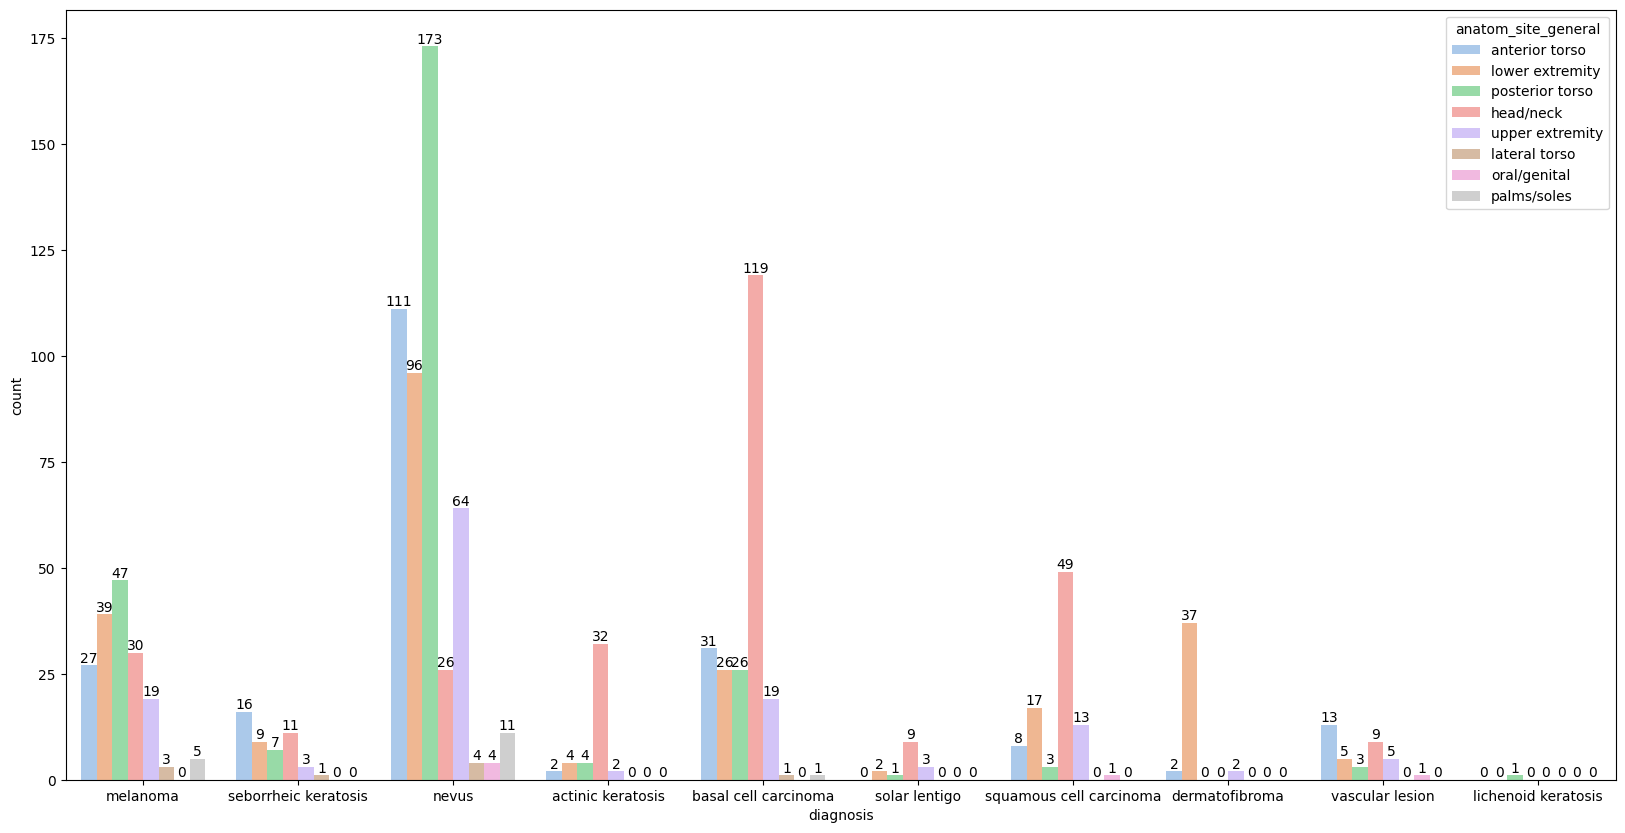

In [100]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x='diagnosis', hue='anatom_site_general', data=lesion_data, palette='pastel')
for i,v in enumerate(lesion_data.anatom_site_general.unique()):
  try:
    ax.bar_label(ax.containers[i])
  except:
    continue